In [1]:
%matplotlib inline

### Code adapted from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


Reinforcement Learning (DQN) tutorial
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`_


In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from functools import reduce
from operator import mul

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

# Gym env
# env = gym.make('CartPole-v0').unwrapped


In [14]:
#  Gathering envrionment

from gathering_mae.single_agent_wrapper import SingleAgentGatheringEnv
from configs.utils import load_config
import cv2

# Get default config

cfg = load_config("configs/static_simple.yaml")

# cfg = load_config("configs/default_env.yaml")

env = SingleAgentGatheringEnv(cfg)
obs_size: torch.Size = env.observation_space
no_actions = 4

Replay Memory
-------------


In [15]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


DQN algorithm
-------------



In [16]:
class DQN(nn.Module):

    def __init__(self, in_size: torch.Size, out_size: torch.Size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_size[0], 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.head = nn.Linear(288, out_size[0])

    def forward(self, x):
        x = F.relu((self.conv1(x)))
        x = F.relu((self.conv2(x)))
        x = F.relu((self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_size: torch.Size, out_size: torch.Size):
        super(MLP, self).__init__()
        in_units = reduce(mul, in_size, 1)
        hidden_size = 256
        self.ln1 = nn.Linear(in_units, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.ln2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.head = nn.Linear(hidden_size, out_size[0])

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.ln1(x)))
        x = F.relu(self.bn2(self.ln2(x)))
        return self.head(x)



Input extraction & processing
^^^^^^^^^^^^^^^^



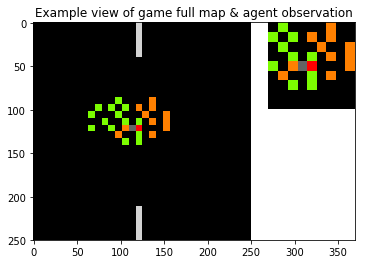

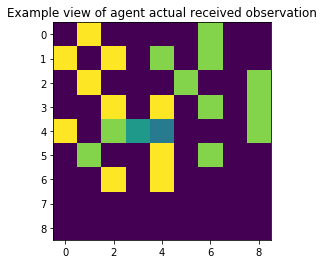

In [17]:
# Vizualize env capture
def convert_obs_to_screen(obs):
    obs = obs.clone()
    obs.mul_(255).int()
    obs = obs.numpy().astype(np.uint8)
    return obs

def process_obs(obs):
    obs = obs.unsqueeze(0).unsqueeze(0)
    obs.add_(-0.6588499999999999).mul_(2.)
    return obs

obs = env.reset()
screen = env.render()
view_obs = convert_obs_to_screen(obs)

# Plot full map + partial 
plt.figure()
plt.imshow(screen,
           interpolation='none')
plt.title('Example view of game full map & agent observation')
plt.show()

# Plot actual observation 
plt.figure()
plt.imshow(view_obs,
           interpolation='none')
plt.title('Example view of agent actual received observation')
plt.show()

In [8]:
### Evaluation & visualization 

def eval_agent(env, model, no_episodes = 5, show = True, waitkey=0):

    model.eval()
    done = True
    env_step = 0
    
    eval_returns = []
    eval_lengths = []
    for ep in range(no_episodes):
        ep_return = 0
        done = False
        state = env.reset()
        env.render(imshow=show)

        for t in count():                

            with torch.no_grad():
                state = process_obs(state).to(device)
                action = model(state).max(1)[1].view(1, 1).item()

            if show:
                key = cv2.waitKey(waitkey) & 0xFF

                # if the 'ESC' key is pressed, Quit
                if key == 27:
                    show = False

            state, r, done, _ = env.step(action)
            ep_return += r

            env.render(imshow=show)

            if done:
                break

        eval_returns.append(ep_return)
        eval_lengths = [t + 1]
        
    print(f"[Eval {i_episode:d}]  Return: {np.mean(eval_returns):5.2f}",
      " | Ep. length:", np.mean(eval_lengths))


# Report info
wait_key = False
print_freq = 1


# screen = env.render()
# cv2.namedWindow("Waikey")
# wait_key = True
# play_game_freq = 1

Training
--------


In [9]:
BATCH_SIZE = 128
GAMMA = 0.4
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 10000
TARGET_UPDATE = 4
EP_START_OPTIM = 2
OPTIMIZE_FREQ = 4

policy_net = DQN(in_size=obs_size, out_size=torch.Size([no_actions])).to(device)
target_net = DQN(in_size=obs_size, out_size=torch.Size([no_actions])).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
memory = ReplayMemory(1000)

steps_done = 0
steps_cnt = 0
episode_durations = []
returns = []

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if steps_done % (EPS_DECAY // 4) == 0:
        print(f"\-- EPS: {eps_threshold}")

    if sample > eps_threshold:
        policy_net.eval()
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(no_actions)]], device=device, dtype=torch.long)


In [10]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### Training loop
^^^^^^^^^^^^^


In [11]:
def optimize_model():
    policy_net.train()

    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8).to(device)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Main training loop




In [12]:
num_episodes = 500
eval_no_episodes = 5
ep_return = 0


In [13]:
#screen = env.render()
#cv.named

for i_episode in range(num_episodes):
    # Initialize the environment and state
    
    state = env.reset()
    state = process_obs(state)
    for t in count():
        # Select and perform an action
        action = select_action(state.to(device))
        action = action.cpu()
        current_screen, reward, done, _ = env.step(action.item())
        current_screen = process_obs(current_screen)

        ep_return += reward
        steps_cnt += 1
        
        reward = torch.tensor([reward])

        # Observe new state
        if not done:
            next_state = current_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward.cpu())

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        if i_episode > EP_START_OPTIM and steps_cnt % OPTIMIZE_FREQ == 0:
            optimize_model()

        if done:
            returns.append(ep_return)
            episode_durations.append(t + 1)
            ep_return = 0
            
            if i_episode % print_freq == 0:
                print(f"[Train {i_episode:d}] Return: {np.mean(returns):5.2f} "
                      f"| Ep. length: {np.mean(episode_durations)}")
                eval_agent(env, policy_net, no_episodes = eval_no_episodes, show = False)
                print()
                
            if wait_key and i_episode % play_game_freq == 0:
                key = cv2.waitKey(1) & 0xFF
                if key == 27:
                    cv2.destroyAllWindows()
                elif key == 113:  # Null action q
                    eval_agent(env, policy_net, no_episodes = 1, show = True)

            # plot_durations()
            break

    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

[Train 0] Return:  3.00 | Ep. length: 100.0
[Eval 0]  Return: 19.00  | Ep. length: 100.0

[Train 1] Return: -7.50 | Ep. length: 100.0
[Eval 1]  Return: -10.80  | Ep. length: 100.0

[Train 2] Return: -7.00 | Ep. length: 100.0
[Eval 2]  Return: -9.40  | Ep. length: 100.0

[Train 3] Return: -4.00 | Ep. length: 100.0
[Eval 3]  Return:  1.00  | Ep. length: 100.0

[Train 4] Return: -5.40 | Ep. length: 100.0
[Eval 4]  Return: 20.20  | Ep. length: 100.0

[Train 5] Return: -4.50 | Ep. length: 100.0
[Eval 5]  Return: -1.00  | Ep. length: 100.0

[Train 6] Return: -2.57 | Ep. length: 100.0
[Eval 6]  Return: -9.40  | Ep. length: 100.0

[Train 7] Return: -1.88 | Ep. length: 100.0
[Eval 7]  Return: -9.40  | Ep. length: 100.0

[Train 8] Return: -1.22 | Ep. length: 100.0
[Eval 8]  Return: 11.20  | Ep. length: 100.0

[Train 9] Return: -0.60 | Ep. length: 100.0
[Eval 9]  Return: 21.40  | Ep. length: 100.0

[Train 10] Return:  0.00 | Ep. length: 100.0
[Eval 10]  Return: 11.20  | Ep. length: 100.0

[Train 

[Eval 88]  Return: 79.60  | Ep. length: 100.0

[Train 89] Return:  7.78 | Ep. length: 100.0
[Eval 89]  Return: 36.80  | Ep. length: 100.0

[Train 90] Return:  7.84 | Ep. length: 100.0
[Eval 90]  Return: 42.80  | Ep. length: 100.0

[Train 91] Return:  7.97 | Ep. length: 100.0
[Eval 91]  Return: 41.40  | Ep. length: 100.0

[Train 92] Return:  8.09 | Ep. length: 100.0
[Eval 92]  Return: 35.00  | Ep. length: 100.0

[Train 93] Return:  8.10 | Ep. length: 100.0
[Eval 93]  Return: 41.40  | Ep. length: 100.0

[Train 94] Return:  8.27 | Ep. length: 100.0
[Eval 94]  Return: 55.40  | Ep. length: 100.0

[Train 95] Return:  8.29 | Ep. length: 100.0
[Eval 95]  Return: 33.80  | Ep. length: 100.0

[Train 96] Return:  8.20 | Ep. length: 100.0
[Eval 96]  Return: 56.20  | Ep. length: 100.0

[Train 97] Return:  8.36 | Ep. length: 100.0
[Eval 97]  Return: 13.20  | Ep. length: 100.0

[Train 98] Return:  8.27 | Ep. length: 100.0
[Eval 98]  Return: 44.00  | Ep. length: 100.0

\-- EPS: 0.38112460785951613
[Tra

KeyboardInterrupt: 